## ANJUMSO

Welcome to **ANJUMSO** - Annotated Jupyter Modelling Software.

In order to run the code, please, install Anaconda 3.8: https://www.anaconda.com/products/individual

After the installation, download (click "code" and choose .zip) the given repository and unpack it on your PC.
In the folder you will find the following files:

1. ANJUMSO.ipynb - JuPyTer notebook, that includes model and auxiliary functions
2. Model Parameters.xlsx - Parameters of the model and model initial conditions that are stored as the Excel file.
You can edit it and this will result in the parameter change in the model. Each module of the model has its own
parameters and they are stored on the corresponding sheets of the Excel file
3. Exp_data.xlsx - ANJUMSO can read and display experimental data for the comparison with the modeling results

Excel files are to be stored in the same folder as the model.

The example model is the model of platelet collagen receptor GPVI and is based on the models from:
Martyanov *et. al.* The Biophys. J. 2020; Garzon Dasgupta *et. al.* Life 2020; Sveshnikova *et. al.* JTH 2016.
Model validation data were taken from: Dunster *et. al.* PLOS Comp. Biol. 2015; Poulter *et. al.* JTH 2017.

To run the model - execute all of the code cells. You can change the parameters of the model dynamically
by passing the model the name of the module, the name of the parameter and the range of the parameter variation.
You can also change the variables that are displayed in the plots by changing of the corresponding variable number.
The instructions for these are given in the corresponding code parts. To run calculation click "Run interact".

Parameter and variable description is given in the excel files.

The model is solved using Python Scipy solve_ivp method, that utilizes LSODA.

res1 and res2 - functions for plotting of the calculation results (see cell 3). Change the number of the variable,
calculated in solution based on the variables, returned by the model
(Variable numbers are given alongside "return"). Depending on the variable type (umol,
uMol, N), variables can be multiplied or denoted by Avogadro Constant (NA), Cytosol Volume (Volume), Plasma
Membrane Area (Area) etc. In the example cytosolic calcium concentration is depicted.


Enjoy!

In [2]:
# Python libraries, used in the model

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets

from ipywidgets import interact_manual, interact
from scipy.integrate import solve_ivp

# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# Model definition

def GPVI_model(time, z, clustering_pars, kinases_pars, pars1, LAT_pars, calcium_pars, PAR_pars):

    # Model variable unpacking. Variables have to be in the same order, as they would be returned by the model.
    # This is critical

    GPVI, GPVI_Act, GPVI_Clust, Ip, Syk, Syk_A, LAT, LAT_p, PIP2, PIP3, PLCg2, PLCg2_A, IP3, \
        Ca_cyt, Ca_dts, Ca_buf, buf,\
        IP3R_n, IP3R_o, IP3R_a, IP3R_i1, IP3R_i2, IP3R_s,\
        Serca2b_e1, Serca2b_e1_ca, Serca2b_e1_2ca, Serca2b_e2, Serca2b_e1_2ca_p, Serca2b_e2_2ca_p, Serca2b_e2_p,\
        par1, sfllrn, thr, par1_a, gqgtp, gqgdp, plcgqgtp, plcgqgdp, par1_gq, \
        gtp, par1_gqgtp, gdp, par1_gqgdp, plcgqgtppip2, plc, pip2, \
        ca_ex, ip3r, \
        orai1_closed, orai1_opened, stim1, stim1ca, ca_mit, phi, mptp_opened, mptp_closed = z

    CRP = kinases_pars['Pars_Horm']['CRP']

    # GPVI clustering module parameters

    kf_act = clustering_pars['Pars_Horm']['Kf_Ligation']
    kr_act = clustering_pars['Pars_Horm']['Kr_Ligation']
    k1 = clustering_pars['Pars_Horm']['k1']
    k2 = clustering_pars['Pars_Horm']['k2']
    k3 = clustering_pars['Pars_Horm']['k3']
    k_1 = clustering_pars['Pars_Horm']['k_1']
    k_2 = clustering_pars['Pars_Horm']['k_2']

    # GPVI clustering module equations

    dGPVIdt = - kf_act * CRP * GPVI + kr_act * GPVI_Act
    dGPVI_Actdt = kf_act * CRP * GPVI - kr_act * GPVI_Act - k1 * GPVI_Clust * GPVI_Act + k_1 * GPVI_Clust - \
                  2 * k2 * GPVI_Act * GPVI_Act
    dGPVI_Clustdt = - (k_2 * GPVI_Clust + k3) * GPVI_Clust + k2 * GPVI_Act * GPVI_Act

    # Tyrosine kinase activation module parameters

    kcat_SFK_A = kinases_pars['Pars_Horm']['kcat_SFK']
    kr_P = kinases_pars['Pars_Horm']['kr_P']
    kcat_CD148 = kinases_pars['Pars_Horm']['kcat_CD148']

    pp_act = kinases_pars['Pars_Horm']['pp_act']
    A = kinases_pars['Pars_Horm']['Monomer_Size'] * 1e-18
    kf_Syk = kinases_pars['Pars_Horm']['kf_Syk']
    kr_Syk = kinases_pars['Pars_Horm']['kr_Syk']
    CD148 = kinases_pars['Pars_Horm']['CD148']

    S = clustering_pars['Pars_Horm']['S']
    V = clustering_pars['Pars_Horm']['V']
    NA = clustering_pars['Pars_Horm']['Avog']

    GPVI_0 = pars1[0]

    # Tyrosine kinase activation module equations

    if GPVI_Clust * S * NA < 1:
        Size = 1
        SFK_A = 0
    else:
        Size = (GPVI_0 - (GPVI_Act + GPVI)) / GPVI_Clust
        if math.isnan(Size):
            Size = 1
        if math.isinf(Size):
            Size = 1
        if abs(Size) > 1000:
            Size = 1
        SFK_A = ((kcat_CD148 / kcat_SFK_A) * Size * (CD148 * pp_act * GPVI_Clust) / (GPVI_Act + GPVI)) ** (1 / 2)

    dIp = kcat_SFK_A * (SFK_A / (Size * A * NA)) * (1 - Ip) / (A * NA) - kr_P * Ip

    dSyk_A = kf_Syk * Ip / (A * NA) * Syk + SFK_A / (Size * A * NA) * kcat_SFK_A * Syk - kr_Syk * Syk_A
    dSyk = - kf_Syk * Ip / (A * NA) * Syk - SFK_A / (Size * A * NA) * kcat_SFK_A * Syk + kr_Syk * Syk_A

    # LAT module parameters

    kcat_Syk = kinases_pars['Pars_Horm']['kcat_Syk']
    KM_Syk = kinases_pars['Pars_Horm']['KM_Syk']
    kr_LAT = kinases_pars['Pars_Horm']['Kr_LAT']
    kD_Syk = kinases_pars['Pars_Horm']['KD_Syk']

    kcat_PI3K = LAT_pars['Pars_Horm']['kcat_PI3K']
    KM_PI3K = LAT_pars['Pars_Horm']['KM_PI3K']
    kr_PIP3 = LAT_pars['Pars_Horm']['kr_PIP3']
    kD_PI3K = LAT_pars['Pars_Horm']['kD_PI3K']
    PI3K = LAT_pars['Pars_Horm']['PI3K'] / (NA * V)

    kcat_Btk = LAT_pars['Pars_Horm']['kcat_Btk']
    KM_Btk = LAT_pars['Pars_Horm']['KM_Btk']
    kD_Btk = LAT_pars['Pars_Horm']['kD_Btk']
    kD_PLCg2 = LAT_pars['Pars_Horm']['kD_PLCg2']
    kr_PLCg2 = LAT_pars['Pars_Horm']['kr_PLCg2']
    Btk = LAT_pars['Pars_Horm']['Btk'] / (NA * V)

    # LAT module equations

    dLATp_dt = kcat_Syk * (Syk_A / (NA * V)) * LAT / (KM_Syk / kD_Syk) - kr_LAT * LAT_p
    dLAT_dt = (- kcat_Syk * (Syk_A / (NA * V)) * LAT / (KM_Syk / kD_Syk) + kr_LAT * LAT_p)

    # PAR Receptor parameters and equations

    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, km_1, km_2, km_3, \
    km_4, km_5, km_6, km_7, km_8, km_9, km_10, km_11, gamma_1, gamma_2, \
    gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, \
    gamma_11, V_1, V_2, K_1, K_2, K_3, k_1, k_2, k_3, k_4, k_5, L1, L3, L5, K3, \
    K5, K6, K7, K8, km2, km3, km4, kc3, k_12, k_13, phi_a1, phi_a2, phi_a3, \
    phi_a4, phi_m, phi_m2, phi_m3, k_thr, jres, F, R, T = PAR_pars

    j1 = k1 * par1 * sfllrn - km_1 * par1_a
    j2 = k2 * par1_a
    j3 = k3 * gqgtp
    j4 = k4 * plcgqgtp
    j5 = k5 * par1_gq * gtp - km_2 * par1_gqgtp
    j6 = k6 * par1_gq * gdp - km_3 * par1_gqgdp
    j7 = k7 * par1_a * gqgdp - km_4 * par1_gqgdp
    j8 = km_5 * par1_gqgtp
    j9 = k8 * plcgqgtppip2
    j10 = k9 * plcgqgtp - km_6 * plc * gqgtp
    j11 = k10 * plcgqgtppip2 - km_7 * pip2 * plcgqgtp
    j12 = k11 * plcgqgdp - km_8 * plc * gqgdp
    jthr = k_thr * par1 * thr

    # PM
    p1 = gamma_1 * np.log(ca_ex / Ca_cyt)
    p2 = (V_1 * np.power(Ca_cyt, 2)) / (K_1 * K_1 + np.power(Ca_cyt, 2))

    # SOCE
    s1 = k_12 * orai1_closed * stim1 - km_10 * orai1_opened
    s2 = k_13 * stim1 * np.power(Ca_dts, 3) - km_11 * stim1ca
    s3 = gamma_4 * orai1_opened * np.log(ca_ex / Ca_cyt)

    # mitochondria
    m1 = gamma_5 / (1 + K6 / ca_mit) * np.exp(F * (phi - phi_a1) / (2 * R * T))
    m2 = gamma_6 * Ca_cyt * np.power((phi - phi_a2), 3) * 2 * F * phi * (Ca_cyt - ca_mit *
                                                                         np.exp(-2 * F * phi / (R * T))) / (
                     R * T * (1 - np.exp(-2 * F * phi / (R * T))) * (K7 * K7 + np.power(Ca_cyt, 2)) *
                     (np.power(phi_m, 3) + np.power(phi - phi_a2, 3)))

    m3 = m2 * gamma_7 / gamma_6
    m4 = m1 * gamma_8 / gamma_5
    m5 = gamma_9 * np.exp(F * phi / (R * T)) - jres
    m6 = gamma_10 * mptp_opened / (1 + np.exp(-(phi - phi_a3) / phi_m2)) - np.power(ca_mit, 4) * \
         mptp_closed * np.exp(-(phi - phi_a4) / phi_m3) / (np.power(K8, 4) + np.power(ca_mit, 4))
    m7 = gamma_11 * mptp_opened * F * phi * (np.exp(F * phi / (R * T)) - np.exp(-F * phi / (R * T))) / (
                R * T * (1 - np.exp(-F * phi / (R * T))))

    dpar1 = -j1 - jthr
    dsfllrn = -j1
    dpar1_a = j1 - j2 - j7 + j8 + jthr
    dgqgtp = -j3 + j8
    dgqgdp = j3 - j7 + j10 + j12
    dplcgqgtp = -j4 + j9 - j10 + j11
    dplcgqgdp = j4 - j12
    dpar1_gq = -j5 - j6
    dgtp = -j5
    dpar1_gqgtp = j5 - j8
    dgdp = -j6
    dpar1_gqgdp = j6 + j7
    dplcgqgtppip2 = -j9 - j11
    dplc = j10 + j12
    dpip2 = 0#j11 #+ j13

    dca_ex = -p1 + p2 - s3

    # print(p1 - p2 + s3 + m1 - m2)
    dca_mit = -m1 + m2
    dphi = -m3 - m4 - m5 - m7
    dmptp_opened = -m6
    dmptp_closed = m6

    dorai1_closed = -s1
    dorai1_opened = s1
    dstim1 = -s2
    dstim1ca = s2

    dthr = 0
    dip3r = 0

    # Calcium Module parameters

    V_IM = calcium_pars['Value']['V_IM']
    V_DTS = calcium_pars['Value']['V_DTS']
    kcat_PLCg2 = calcium_pars['Value']['kcat_PLCg2']
    KM_PLCg2 = calcium_pars['Value']['KM_PLCg2']
    kr_IP3 = calcium_pars['Value']['kr_IP3']
    kf_Buf = calcium_pars['Value']['kf_Buf']
    kr_Buf = calcium_pars['Value']['kr_Buf']

    O_1 = V_IM * 0.12 * 11.94 / (0.12 + Ca_cyt)
    O_2 = V_IM * 90.56
    O_3 = V_IM * 1.7768 / (0.12 + Ca_cyt)
    O_4 = V_IM * 0.84
    O_5 = V_IM * (37.4 * 0.025 + 1.7 * Ca_cyt) / (0.025 + Ca_cyt * 0.145 / 0.12)
    O_6 = V_IM * (1.4 + Ca_cyt * 2.5)
    O_7 = V_IM * 1.7768 / (0.12 + Ca_cyt * 0.145 / 0.12)
    IP3R_num = V_IM * (IP3R_a + IP3R_i1 + IP3R_i2 + IP3R_n + IP3R_o + IP3R_s)
    O_P0 = (V_IM * (0.9 * IP3R_a + 0.1 * IP3R_o) / IP3R_num)**5.5

    I_1 = V_IM * 160
    I_2 = V_IM * 940
    I_3 = V_IM * 1.6
    I_4 = V_IM * 900
    I_5 = V_IM * 250
    I_6 = V_IM * 8e-5
    I_7 = V_IM

    # Calcium Module equations

    dPIP3 = (S/V) * kcat_PI3K * (LAT_p * PI3K / kD_PI3K) * PIP2 / (KM_PI3K / kD_PI3K + PIP2) - kr_PIP3 * PIP3
    dPIP2 = - (S/V) * kcat_PI3K * (LAT_p * PI3K / kD_PI3K) * PIP2 / (KM_PI3K / kD_PI3K + PIP2) \
            + kr_PIP3 * PIP3 - kcat_PLCg2 * PIP2 * PLCg2_A / (KM_PLCg2 / kD_PLCg2) * Ca_cyt / (Ca_cyt + 0.2) \
            + kr_IP3 * IP3 - j9 * 10
    #- \
            # (kcat_PLCg2 * PLCg2_A * PIP2 * (S / V) / (KM_PLCg2 / kD_PLCg2) * Ca_cyt / (Ca_cyt + 0.2)
            #      - kr_IP3 * IP3) / S

    dIP3 = kcat_PLCg2 * PIP2 * PLCg2_A / (KM_PLCg2 / kD_PLCg2) * Ca_cyt / (Ca_cyt + 0.2) - kr_IP3 * IP3 \
           + (O_6 * IP3R_o - O_5 * IP3R_n * IP3) / V + j9 * 10

    # dIP3 = (kcat_PLCg2 * PLCg2_A * PIP2 * (S / V) / (KM_PLCg2 / kD_PLCg2) * Ca_cyt / (Ca_cyt + 0.2)
    #             - kr_IP3 * IP3)/V# + O_6 * IP3R_o - O_5 * IP3R_n * IP3) / V + j9 * 1e13

    dPLCg2_A = (S/V) * kcat_Btk * (PIP3 * Btk / kD_Btk) \
               * (PLCg2 * LAT_p / kD_PLCg2) / (KM_Btk / kD_Btk + (PLCg2 * LAT_p / kD_PLCg2)) - kr_PLCg2 * PLCg2_A
    dPLCg2 = - (S/V) * kcat_Btk * (PIP3 * Btk / kD_Btk) \
             * (PLCg2 * LAT_p / kD_PLCg2) / (KM_Btk / kD_Btk + (PLCg2 * LAT_p / kD_PLCg2)) - kr_PLCg2 * PLCg2_A

    # print(IP3, dIP3)

    dCa_cyt = (0.1351 * I_7 * math.log(Ca_dts / Ca_cyt)
               + 800 * IP3R_num * O_P0 * math.log(Ca_dts / Ca_cyt)
               - O_2 * IP3R_o * Ca_cyt + O_1 * IP3R_a - O_7 * IP3R_n * Ca_cyt + O_4 * IP3R_i1
               - O_3 * IP3R_a * Ca_cyt + O_4 * IP3R_i2
               + I_1 * Serca2b_e1_ca - I_2 * Serca2b_e1 * Ca_cyt
               + I_3 * Serca2b_e1_2ca - I_4 * Serca2b_e1_ca * Ca_cyt
               - V * 4 * kf_Buf * Ca_cyt**4 * buf + V * 4 * kr_Buf * Ca_buf) / V + p1 - p2 + s3 + m1 - m2

    dCa_dts = (- 0.1351 * I_7 * math.log(Ca_dts / Ca_cyt)
               - 800 * IP3R_num * O_P0 * math.log(Ca_dts / Ca_cyt)
               + 2 * I_5 * Serca2b_e2_2ca_p - 2 * I_6 * Serca2b_e2_p * Ca_dts**2) / V_DTS - s2 / 3

    dbuf = (- V * 4 * kf_Buf * Ca_cyt**4 * buf + 4 * V * kr_Buf * Ca_buf) / V

    dCa_buf = (V * 4 * kf_Buf * Ca_cyt**4 * buf - V * 4 * kr_Buf * Ca_buf) / V

    dIP3R_n = (- O_5 * IP3R_n * IP3 + O_6 * IP3R_o + O_4 * IP3R_i1 - O_7 * IP3R_n * Ca_cyt) / V_IM

    dIP3R_o = (O_1 * IP3R_a - O_2 * IP3R_o * Ca_cyt + O_5 * IP3R_n * IP3 - O_6 * IP3R_o
                + V_IM * 29.8 * IP3R_s - V_IM * 0.11 * IP3R_o) / V_IM

    dIP3R_a = (- O_1 * IP3R_a + O_2 * IP3R_o * Ca_cyt + O_4 * IP3R_i2 - O_3 * IP3R_a * Ca_cyt) / V_IM

    dIP3R_i1 = (- O_4 * IP3R_i1 + O_7 * IP3R_n * Ca_cyt) / V_IM

    dIP3R_i2 = (- O_4 * IP3R_i2 + O_3 * IP3R_a * Ca_cyt) / V_IM

    dIP3R_s = (- V_IM * 29.8 * IP3R_s + V_IM * 0.11 * IP3R_o) / V_IM

    dSerca2b_e1 = (I_1 * Serca2b_e1_ca - I_2 * Serca2b_e1 * Ca_cyt
                   - V_IM * 200 * Serca2b_e1 + V_IM * 280 * Serca2b_e2) / V_IM

    dSerca2b_e1_2ca = (- I_3 * Serca2b_e1_2ca + I_4 * Serca2b_e1_ca * Ca_cyt
                       + V_IM * 60 * Serca2b_e1_2ca_p - V_IM * 600 * Serca2b_e1_2ca) / V_IM

    dSerca2b_e1_2ca_p = (- V_IM * 60 * Serca2b_e1_2ca_p + V_IM * 600 * Serca2b_e1_2ca
                         + V_IM * 25 * Serca2b_e2_2ca_p - V_IM * 65 * Serca2b_e1_2ca_p) / V_IM

    dSerca2b_e1_ca = (- I_1 * Serca2b_e1_ca + I_2 * Serca2b_e1 * Ca_cyt
                      + I_3 * Serca2b_e1_2ca - I_4 * Serca2b_e1_ca * Ca_cyt) / V_IM

    dSerca2b_e2 = (V_IM * 105 * Serca2b_e2_p - V_IM * 1.6 * Serca2b_e2
                   + V_IM * 200 * Serca2b_e1 - V_IM * 280 * Serca2b_e2) / V_IM

    dSerca2b_e2_2ca_p = (- V_IM * 25 * Serca2b_e2_2ca_p + V_IM * 65 * Serca2b_e1_2ca_p
                          - I_5 * Serca2b_e2_2ca_p + I_6 * Serca2b_e2_p * Ca_dts**2) / V_IM

    dSerca2b_e2_p = (I_5 * Serca2b_e2_2ca_p - I_6 * Serca2b_e2_p * Ca_dts**2
                     - V_IM * 105 * Serca2b_e2_p + V_IM * 1.6 * Serca2b_e2) / V_IM

    # print(dCa_cyt, dca_cyt)

    return [dGPVIdt, dGPVI_Actdt, dGPVI_Clustdt, dIp, dSyk,  # 0 - 4
            dSyk_A, dLAT_dt, dLATp_dt, dPIP2, dPIP3,  # 5 - 9
            dPLCg2, dPLCg2_A, dIP3,  # 10 - 12
            dCa_cyt, dCa_dts, dCa_buf, dbuf,  # 13 - 16
            dIP3R_n, dIP3R_o, dIP3R_a, dIP3R_i1, dIP3R_i2, dIP3R_s,  # 17 - 22
            dSerca2b_e1, dSerca2b_e1_ca, dSerca2b_e1_2ca, dSerca2b_e2, dSerca2b_e1_2ca_p,  # 23 - 27
            dSerca2b_e2_2ca_p, dSerca2b_e2_p,  # 28 - 29
            dpar1, dsfllrn, dthr, dpar1_a, dgqgtp, dgqgdp, dplcgqgtp, dplcgqgdp, dpar1_gq,  # 30 - 38
            dgtp, dpar1_gqgtp, dgdp, dpar1_gqgdp, dplcgqgtppip2, dplc, dpip2,  # 39 - 46
            dca_ex, dip3r,  # 47 - 56
            dorai1_closed, dorai1_opened, dstim1, dstim1ca, dca_mit, dphi, dmptp_opened, dmptp_closed]

In [4]:
%matplotlib inline
def plotter(time, data, plot_list, plot_dict, initial_cond_dict,
            V_Cyt, S_PM, NA):

    model_variables = list(plot_dict.keys())
    # size = [0, ]
    # for i in range(1, len(data[0])):
    #     size.append((initial_cond_dict['GPVI'] - data[0][i] - data[1][i]) /
    #                     (data[2][i]))

    def single_plot_data(Variable=plot_list[0], Multiplier=1, Export=False,
                         Dualplot=True, Secondplot=plot_list[1],
                         Sec_Multiplier=1):

        if Export:
            data_out = list(map(list, zip(*data)))
            df_out = pd.DataFrame(data_out, columns=model_variables)
            df_out['Time'] = time
            df_out.set_index('Time').to_excel('Model_Output.xlsx')

        plotting_data = []
        for i in range(len(data[plot_dict[Variable]])):
            plotting_data.append(data[plot_dict[Variable]][i] * Multiplier)

        plt.plot(time, plotting_data, label=Variable)

        if Dualplot:
            dualplotting_data = []
            for i in range(len(data[plot_dict[Variable]])):
                dualplotting_data.append(data[plot_dict[Secondplot]][i] *
                                         Sec_Multiplier)

            plt.plot(time, dualplotting_data, label=Secondplot)

        plt.legend()

        # If you want to add experimental data, specify the sheet with the data and provide the names of the columns
        # in the Exp_data file. Then, uncomment the line "plt.scatter(timepoints, val)" and your experimental data
        # will appear on the selected plot.

        # data = pd.read_excel('Exp_data.xlsx', sheet_name='SykY525')

        # timepoints = data['Time']
        # val = data['Syk']
        # plt.scatter(timepoints, val)

        plt.show()

    multipliers = [('None', 1),
                    ('To uMols from units (Cytosol)', 1 / (NA * V_Cyt)),
                    ('To units from uMols (Cytosol)', (NA * V_Cyt)),
                    ('To umols / m^2 from units (Membrane)', 1 / (NA * S_PM)),
                    ('To units from umols / m^2 (Membrane)', (NA * S_PM))]

    # model_var_drop = widgets.Dropdown(options=model_variables)
    # mult_var_drop = widgets.Dropdown(options=multipliers)
    # butt.on_click(on_butt_clicked)

    # widgets.VBox([model_var_drop, multipliers, butt,outt])

    interact_manual(single_plot_data, Variable=model_variables, Multiplier=multipliers,
                    Export=[('No', False), ('Yes', True)],
                    Dualplot=[('No', False), ('Yes', True)],
                    Secondplot=model_variables,
                    Sec_Multiplier=multipliers)

    # interact_manual(model_output())

In [5]:
# Model calculation and plotting

def plot_model(clust_pars, kin_pars, LAT_pars, calcium_pars, PAR1_initial, PAR1_parameters,
               InitCond, time_calc, ssteps, varying_list, plot_list):

    # clust_pars - clustering module parameters
    # kin_pars - kinase module parameters
    # LAT_pars - LAT module parameters
    # calcium_pars - Calcium module parameters
    # InitCond - Initial conditions
    # time_calc - maximal time of calculation
    # ssteps - number of timesteps
    # varying list - list of parametes, varied, using sliders

    def slidercalc(**kwargs):

        keylist = list(kwargs.keys())

        for j in range(len(keylist)):
            if keylist[j].split('.')[0] == 'Initial':
                InitCond['Value'][keylist[j].split('.')[1]] = \
                    kwargs[keylist[j]]
            if keylist[j].split('.')[0] == 'Clustering':
                clust_pars['Pars_Horm'][keylist[j].split('.')[1]] = \
                    kwargs[keylist[j]]
            if keylist[j].split('.')[0] == 'KinaseActivation':
                kin_pars['Pars_Horm'][keylist[j].split('.')[1]] = \
                    kwargs[keylist[j]]
            if keylist[j].split('.')[0] == 'LAT_Pars':
                LAT_pars['Pars_Horm'][keylist[j].split('.')[1]] = \
                    kwargs[keylist[j]]
            if keylist[j].split('.')[0] == 'calcium_pars':
                calcium_pars['Value'][keylist[j].split('.')[1]] = \
                    kwargs[keylist[j]]
            if keylist[j].split('.')[0] == 'PAR1_Initial':
                PAR1_initial['Value'][keylist[j].split('.')[1]] = \
                    kwargs[keylist[j]]

        NA = 6.02e17
        Volume = clust_pars['Pars_Horm']['V']
        Area = clust_pars['Pars_Horm']['S']

        initial_cond_dict = {'GPVI': InitCond['Value']['GPVI'] / (NA * Area),
                             'GPVI_Act': InitCond['Value']['GPVI_Act'] / (NA * Area),
                             'GPVI_Clust': InitCond['Value']['Clusters'] / (NA * Area),
                             'Ip': InitCond['Value']['Ip'],
                             'Syk': InitCond['Value']['Syk'],
                             'Syk_A': InitCond['Value']['Syk_A'],
                             'LAT': InitCond['Value']['LAT'] / (NA * Area),
                             'LAT_p': InitCond['Value']['LAT_p'] / (NA * Area),
                             'PIP2': InitCond['Value']['PIP2'] / (NA * Area),
                             'PIP3': InitCond['Value']['PIP3'] / (NA * Area),
                             'PLCg2': InitCond['Value']['PLCg2'] / (NA * Volume),
                             'PLCg2_A': InitCond['Value']['PLCg2_A'] / (NA * Volume),
                             'IP3': InitCond['Value']['IP3'],
                             'Ca_cyt': InitCond['Value']['Ca_cyt'],
                             'Ca_dts': InitCond['Value']['Ca_dts'],
                             'Ca_buf': InitCond['Value']['Ca_buf'],
                             'buf': InitCond['Value']['buf'],
                             'IP3R_n': InitCond['Value']['IP3R_n'],
                             'IP3R_o': InitCond['Value']['IP3R_o'],
                             'IP3R_a': InitCond['Value']['IP3R_a'],
                             'IP3R_i1': InitCond['Value']['IP3R_i1'],
                             'IP3R_i2': InitCond['Value']['IP3R_i2'],
                             'IP3R_s': InitCond['Value']['IP3R_s'],
                             'Serca2b_e1': InitCond['Value']['Serca2b_e1'],
                             'Serca2b_e1_ca': InitCond['Value']['Serca2b_e1_ca'],
                             'Serca2b_e1_2ca': InitCond['Value']['Serca2b_e1_2ca'],
                             'Serca2b_e2': InitCond['Value']['Serca2b_e2'],
                             'Serca2b_e1_2ca_p': InitCond['Value']['Serca2b_e1_2ca_p'],
                             'Serca2b_e2_2ca_p': InitCond['Value']['Serca2b_e2_2ca_p'],
                             'Serca2b_e2_p': InitCond['Value']['Serca2b_e2_p'],
                             'par1': PAR1_initial['Value']['par1'],
                             'thr': PAR1_initial['Value']['thr'],
                             'sfllrn': PAR1_initial['Value']['sfllrn'],
                             'par1_a': PAR1_initial['Value']['par1_a'],
                             'gqgtp': PAR1_initial['Value']['gqgtp'],
                             'gqgdp': PAR1_initial['Value']['gqgdp'],
                             'plcgqgtp': PAR1_initial['Value']['plcgqgtp'],
                             'plcgqgdp': PAR1_initial['Value']['plcgqgdp'],
                             'par1_gq': PAR1_initial['Value']['par1_gq'],
                             'gtp': PAR1_initial['Value']['gtp'],
                             'par1_gqgtpgdp': PAR1_initial['Value']['par1_gqgtpgdp'],
                             'gdp': PAR1_initial['Value']['gdp'],
                             'par1_gqgdp': PAR1_initial['Value']['par1_gqgdp'],
                             'plcgqgtppip2': PAR1_initial['Value']['plcgqgtppip2'],
                             'plc': PAR1_initial['Value']['plc'],
                             'pip2': PAR1_initial['Value']['pip2'],
                             'ca_ex': PAR1_initial['Value']['ca_ex'],
                             'ip3r': PAR1_initial['Value']['ip3r'],
                             'orai1_closed': PAR1_initial['Value']['orai1_closed'],
                             'orai1_opened': PAR1_initial['Value']['orai1_opened'],
                             'stim1': PAR1_initial['Value']['stim1'],
                             'stim1ca': PAR1_initial['Value']['stim1ca'],
                             'ca_mit': PAR1_initial['Value']['ca_mit'],
                             'phi': PAR1_initial['Value']['phi'],
                             'mptp_opened': PAR1_initial['Value']['mptp_opened'],
                             'mptp_closed': PAR1_initial['Value']['mptp_closed']}

        Initial = list(initial_cond_dict.values())
        initial_names = list(initial_cond_dict.keys())

        plot_dict = {}
        for i in range(len(Initial)):
            plot_dict[initial_names[i]] = i

        model_calc = solve_ivp(GPVI_model, [0, time_calc], Initial,
                                   args=(clust_pars, kin_pars, Initial, LAT_pars, calcium_pars, PAR1_parameters, ),
                                   max_step=100000,
                                   dense_output=True, method='LSODA', rtol=1e-6, atol=1e-12)
        time = np.linspace(0, time_calc, ssteps)
        solution = model_calc.sol(time)

        transposed = list(map(list, zip(*solution.T)))

        plotter(time,
                transposed,
                plot_list,
                plot_dict,
                initial_cond_dict,
                V_Cyt=Volume,
                S_PM=Area,
                NA=NA)

        # return res2

    def gen_slider(input_list):
        if input_list[0] == 'KinaseActivation':
            return widgets.FloatSlider(
                value=kin_pars['Pars_Horm'][input_list[1]],
                min=input_list[2],
                max=input_list[3],
                step=(input_list[3] - input_list[2]) / 1000,
                description=input_list[1],
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.5f')
        elif input_list[0] == 'Clustering':
            return widgets.FloatSlider(
                value=clust_pars['Pars_Horm'][input_list[1]],
                min=input_list[2],
                max=input_list[3],
                step=(input_list[3] - input_list[2]) / 1000,
                description=input_list[1],
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.5f')
        if input_list[0] == 'LAT_Pars':
            return widgets.FloatSlider(
                value=LAT_pars['Pars_Horm'][input_list[1]],
                min=input_list[2],
                max=input_list[3],
                step=(input_list[3] - input_list[2]) / 1000,
                description=input_list[1],
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.5f')
        if input_list[0] == 'calcium_pars':
            return widgets.FloatSlider(
                value=calcium_pars['Value'][input_list[1]],
                min=input_list[2],
                max=input_list[3],
                step=(input_list[3] - input_list[2]) / 1000,
                description=input_list[1],
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.5f')
        if input_list[0] == 'Initial':
            return widgets.FloatSlider(
                value=InitCond['Value'][input_list[1]],
                min=input_list[2],
                max=input_list[3],
                step=(input_list[3] - input_list[2]) / 100,
                description=input_list[1],
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.5f')
        if input_list[0] == 'PAR1_Initial':
            return widgets.FloatSlider(
                value=PAR1_initial['Value'][input_list[1]],
                min=input_list[2],
                max=input_list[3],
                step=(input_list[3] - input_list[2]) / 100,
                description=input_list[1],
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.5f')

    weight_sliders = [gen_slider(varying_list[i])
                      for i in range(len(varying_list))]

    kwargs = {varying_list[i][0] + '.' + varying_list[i][1]:
              slider for i, slider in enumerate(weight_sliders)}

    interact_manual(slidercalc, **kwargs)

In [7]:
clustering_pars = pd.read_excel('Model_Parameters.xlsx', sheet_name='Clustering').set_index('Parname')
kinase_pars = pd.read_excel('Model_Parameters.xlsx', sheet_name='KinaseActivation').set_index('Parname')
InitialValues = pd.read_excel('Model_Parameters.xlsx', sheet_name='InitialConcentrations').set_index('Name')
LAT_pars = pd.read_excel('Model_Parameters.xlsx', sheet_name='LAT_Pars').set_index('Parname')
calcium_pars = pd.read_excel('Model_Parameters.xlsx', sheet_name='CalciumModule').set_index('Parname')

PAR1_init = pd.read_excel('Model_Parameters.xlsx', sheet_name='InitPAR1').set_index('Name')
PAR1_pars = pd.read_excel('Model_Parameters.xlsx', sheet_name='PAR1').set_index('Name')['Value'].tolist()

# List of modules, in which parameters can be varied
# clustering_pars - clustering module parameters
# kinase_pars - kinase module parameters
# LAT_pars - LAT module parameters
# calcium_pars - Calcium module parameters
# InitialValues - Initial conditions
# PAR1_Initial - Initial conditions for PAR1 module

# To generate the slider, add to the varying list parameter of the plot_model function:
# [Name of the module, Name of the desired parameter,
# min value, max value]. E.g. you want to create slider for the initial concentration of SFLLRN:
# It can be found in the PAR1_Initial module, see names on the corresponding sheet in Model_Parameters.xlsx.
# So, you add:
# ['PAR1_Initial', 'sfllrn', 0, 100]
# You can generate as many parameters, as you wish

# To the parameter plot_list you pass list of lists, where each element is:
# [Name of the variable you want to plot,

plot_model(clustering_pars, kinase_pars, LAT_pars, calcium_pars,
           InitCond=InitialValues, PAR1_initial=PAR1_init, PAR1_parameters=PAR1_pars,
           time_calc=300, ssteps=1000,
           varying_list = [['Initial', 'GPVI', 1000, 10000],
                           ['Initial', 'buf', 0, 30],
                           ['Initial', 'Syk', 1000, 10000],
                           ['LAT_Pars', 'kr_PLCg2', 0.01, 0.1],
                           ['calcium_pars', 'kf_Buf', 0.1, 50],
                           ['KinaseActivation', 'CRP', 0, 100],
                           ['PAR1_Initial', 'par1', 0, 1],
                           ['PAR1_Initial', 'sfllrn', 0, 100]],
           plot_list=['Ca_cyt', 'Ca_dts'])

interactive(children=(FloatSlider(value=5000.0, continuous_update=False, description='GPVI', max=10000.0, min=…

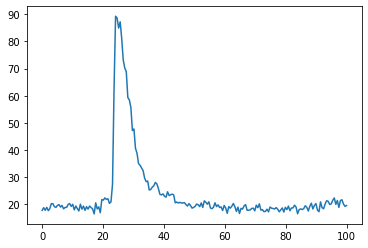

[17.814 18.808 17.84  18.923 17.692 18.474 20.282 20.282 19.173 18.91
 19.635 19.923 19.026 19.622 18.372 18.917 18.897 20.006 20.308 19.282
 20.032 18.    19.417 18.455 17.603 20.096 18.263 19.385 17.821 19.173
 18.269 19.397 18.833 18.295 16.506 20.577 18.353 19.096 16.962 21.788
 21.583 22.397 21.872 22.077 20.378 20.981 27.417 62.647 89.282 88.609
 84.923 87.231 81.122 73.212 70.237 68.872 59.391 58.468 55.756 47.192
 47.788 40.692 38.891 35.051 34.429 33.462 32.417 29.673 28.385 28.609
 25.295 25.519 26.378 26.865 28.09  27.538 25.808 23.692 23.506 23.885
 23.032 22.686 24.654 23.269 23.564 23.795 23.494 20.59  20.885 20.5
 20.763 20.545 20.519 20.654 19.955 19.404 20.288 19.577 18.641 18.878
 19.295 20.128 19.897 19.186 20.551 18.885 21.321 20.814 20.077 20.949
 18.712 18.423 18.949 20.59  19.192 19.853 18.885 19.071 17.75  19.615
 18.705 16.731 19.186 18.622 19.346 20.333 19.179 17.404 19.    16.66
 18.558 18.269 19.449 19.929 17.846 17.878 17.968 18.532 18.615 17.654
 19.718 18

In [9]:
data = np.load('spike.txt.npy')
time_2 = np.linspace(0, 100, len(data))

plt.plot(time_2, data)

plt.show()
print(data)